https://github.com/SheffieldML/GPy/issues/623
optimizing over set parameters

Optimization is done:
<br>
Optimize the model using self.log_likelihood and self.log_likelihood_gradient, 
as well as self.priors. kwargs are passed to the optimizer. They can be:

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
import GPy
from sklearn.metrics import mean_squared_error

 sMSE is the mean squared error (MSE) of true and predicted values, divided by the variance of the true values. 

##  Implment for all the datasets

plotting and visualization methods, holosview,

each chromosome show with and without optimization, scatter plot of data, along with annotated correlation constants

line plot/bar plot of different chromosomes

line plot showing how correlation changes as train/test partitions vary

show confidence intervals running multiple times changing the seed

for gp method, implement with ard kernel, add other kernels to see effect

probably better just scatter plot of each chromosome and visualize all plots at once

how to evaluate performance of gp regression?

visualize variogram

10 fold cross validation (leave one out? maybe)


implement 2,3,4,5,10 various fold cv, rbf kerenl ard mode, plot for each chromosomes, and plot for all data together, store kernel parameters (length scale, variance)

Way of plotting back onto chromosome position/rna-seq level/protomics level

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/cross_validation.html

https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#pre-filtering-the-dataset

In [ ]:
#Class for fast testing of Gpy

class GPY():
    def __init__(self,pdDF,zscore = True):
        self.data

In [19]:
gp_data = pd.read_csv('Data/GP_data.tsv',sep='\t',index_col=0)
base_cols = ['Gene.names','Gene.description','AvgChrs','NormPosition','Gene Length']
gp_data.head()

,Gene.names,Gene.description,AvgChrs,AT2_04M_F0,AT2_18M_F0,AT2_04M_F10,AT2_18M_F10,AM_04M_F0,AM_18M_F0,AM_04M_F10,...,Gene Length,AM_18M_F0_P,AM_04M_F0_P,AM_18M_F10_P,AM_04M_F10_P,AT2_18M_F0_P,AT2_04M_F0_P,AT2_18M_F10_P,AT2_04M_F10_P,NormPosition
Row.names,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,Gnai3,guanine nucleotide binding protein (G protein)...,2.675624,7.151432,7.134999,7.301802,7.126699,7.808586,7.735874,7.599455,...,38866,25.398656,25.29266,25.440647,25.149847,25.344119,25.38975,25.402401,25.485167,0.675624
ENSMUSG00000000028,Cdc45,cell division cycle 45,15.191392,1.347537,0.520289,1.752669,1.091367,2.649199,1.417394,3.991956,...,31540,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.191392
ENSMUSG00000000056,Narf,nuclear prelamin A recognition factor,10.993152,4.248040,4.163523,4.249110,4.224477,4.329426,3.781370,4.352047,...,18603,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.993152
ENSMUSG00000000058,Cav2,caveolin 2,5.115437,6.162987,5.953024,6.113755,5.937759,6.605884,7.103410,6.679218,...,7930,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.115437
ENSMUSG00000000078,Klf6,Kruppel-like factor 6,12.048712,6.635019,6.649572,6.795728,6.626275,8.641117,8.631336,8.324152,...,8912,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.048712


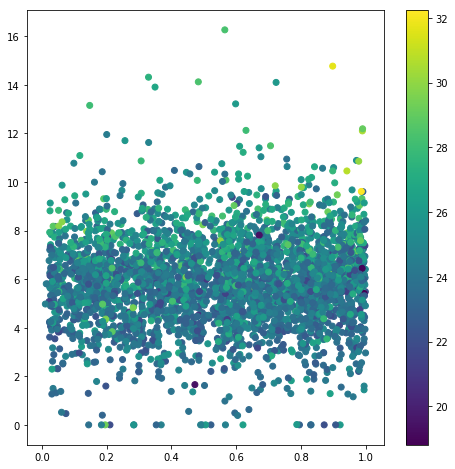

In [26]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
AT2_04M_F0 = gp_data[base_cols+['AT2_04M_F0','AT2_04M_F0_P']][gp_data['AT2_04M_F0_P']!=0]
sc = ax.scatter(AT2_04M_F0['NormPosition'],AT2_04M_F0['AT2_04M_F0'],c=AT2_04M_F0['AT2_04M_F0_P'],cmap = cm.viridis)
plt.colorbar(sc)

In [29]:
AT2_04M_F0.shape

(3561, 7)

In [56]:
vsp_data = pd.read_csv('../Data/vsp_input.tsv',sep='\t')
vsp_data = vsp_data[vsp_data['WSU_Old']!=17] #Removes psudovalues
vsp_data['gene length'] = np.log2(vsp_data['gene length'])
vsp_data.set_index('Gene.names',inplace=True)
vsp_data.drop(columns='Gene.description',inplace=True)

(3807, 8)
(3581, 8)


In [61]:
set(vsp_data['AvgChrs'].astype(int))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [33]:
np.random.seed(1)

In [34]:
vsp_data = pd.read_csv('../Data/vsp_input.tsv',sep='\t')
chrm1_data = vsp_data[vsp_data['AvgChrs']<=1]
chrm1_data = chrm1_data[chrm1_data['WSU_Old']!=17]
chrm1_data['gene length'] = np.log2(chrm1_data['gene length'])
chrm1_data.set_index('Gene.names',inplace=True)
chrm1_data.drop(columns='Gene.description',inplace=True)

In [35]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.8

msk = np.random.rand(len(chrm1_data)) < data_percent
train_chrm1 = chrm1_data[msk]
test_chrm1 = chrm1_data[~msk]

In [36]:
means = train_chrm1.mean(axis=0)
stds = train_chrm1.std(axis=0)
train_chrm1 = (train_chrm1-means)/stds
test_chrm1 = (test_chrm1-means)/stds

In [37]:
x=train_chrm1[['gene length','AT2_18M_F10']].values
y=train_chrm1[['WSU_Old']].values
x_test = test_chrm1[['gene length','AT2_18M_F10']].values
y_truth=test_chrm1[['WSU_Old']].values

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


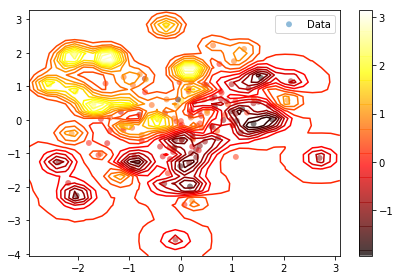

In [42]:
d = 2 # input dimension
var = 1. # variance
theta = 0.2 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
m = GPy.models.GPRegression(x,y,k)
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

In [46]:
predicted = m.predict(x_test)
y_predicted = predicted[0]

pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
spearmanrho = scipy.stats.spearmanr(y_truth,y_predicted)
sMSE = mean_squared_error(y_truth,y_predicted)/np.var(y_truth)
print(f'pearson r {pearsonr}')
print(f'spearman rho {spearmanrho}')
print(f'sMSE {sMSE}, MSE {mean_squared_error(y_truth,y_predicted)}')

pearson r (array([0.41580831]), array([0.00762037]))
spearman rho SpearmanrResult(correlation=0.5527204502814259, pvalue=0.00021699858650151214)
sMSE 0.8423871656271423, MSE 1.2278393212289782


In [47]:
m.optimize(messages=1, ipython_notebook=True)

pearson r (array([0.70321495]), array([4.18914782e-07]))
spearman rho SpearmanrResult(correlation=0.6348968105065667, pvalue=1.0810302288400107e-05)
sMSE 0.6293437612472706, MSE 0.9173133781712532


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


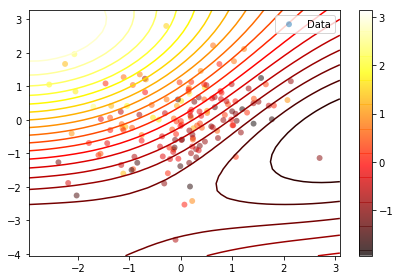

In [49]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

predicted = m.predict(x_test)
y_predicted = predicted[0]

pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
spearmanrho = scipy.stats.spearmanr(y_truth,y_predicted)
sMSE = mean_squared_error(y_truth,y_predicted)/np.var(y_truth)

print(f'pearson r {pearsonr}')
print(f'spearman rho {spearmanrho}')
print(f'sMSE {sMSE}, MSE {mean_squared_error(y_truth,y_predicted)}')

In [54]:
m.kern.lengthscale[1]

2.9450350944264576